In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('bmh')

In [19]:
df = pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [21]:
df.rename(columns={'PAY_0': 'PAY_1', 'default.payment.next.month': 'default'}, inplace=True)

In [22]:
# check duplicates

df[df.duplicated()]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default


### Target distibution

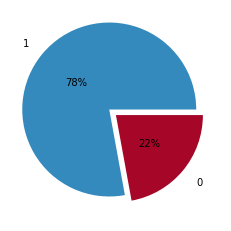

In [23]:
plt.pie(df['default'].value_counts(), 
        labels=df['default'].unique(),
        autopct='%1.0f%%', 
        pctdistance=0.5, 
        labeldistance=1.2,
        explode=(0.1, 0))
plt.show()

### Features distribution

In [24]:
df.drop('ID', axis=1, inplace=True)
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
num_cols = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

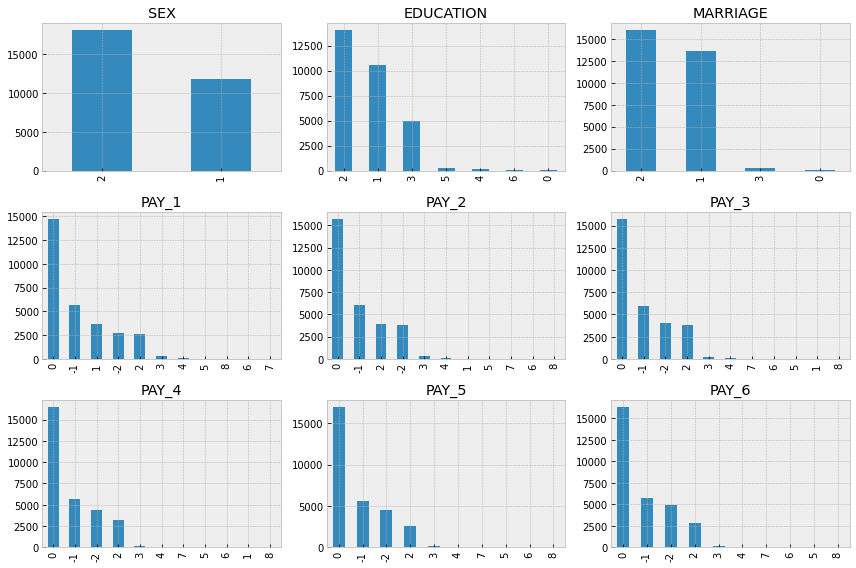

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(12, 8))
for i, cat_feature in enumerate(df[cat_cols]):
    df[cat_feature].value_counts().plot(kind='bar', ax=ax[i // 3][i % 3]).set_title(cat_feature)

fig.tight_layout()
plt.show()

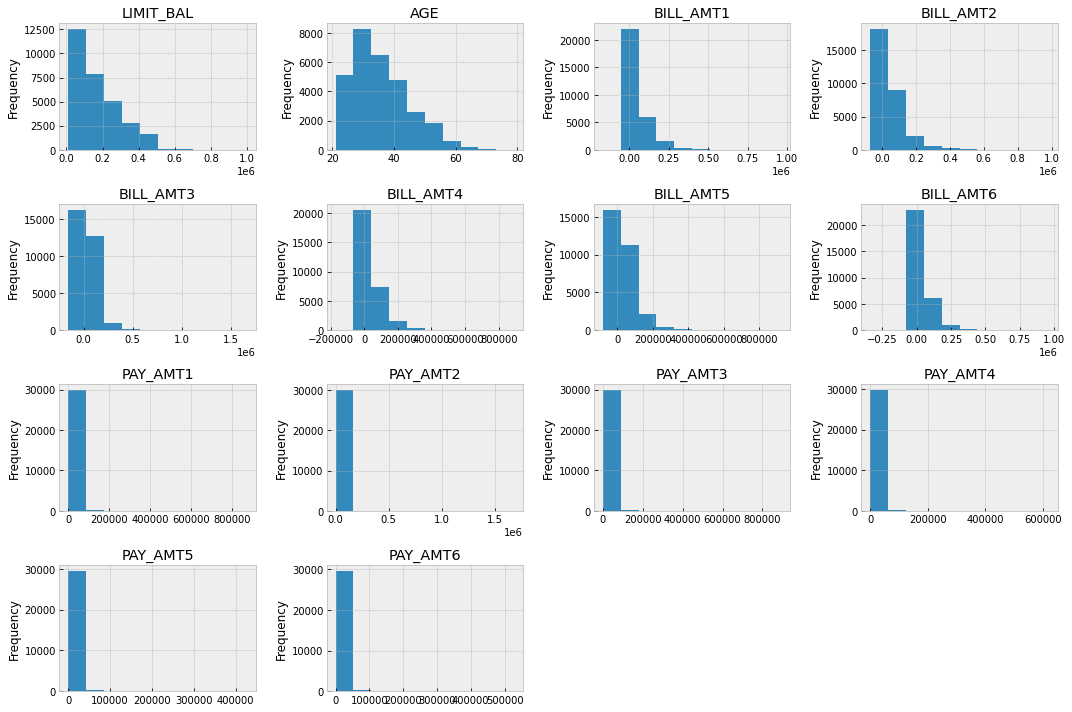

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for i, num_feature in enumerate(df[num_cols]):
    df[num_feature].plot(kind='hist', ax=ax[i // 4][i % 4]).set_title(num_feature)
    
fig.tight_layout()
for i in range(2, 4):
    ax[3][i].remove()
plt.show()

### Features correlation

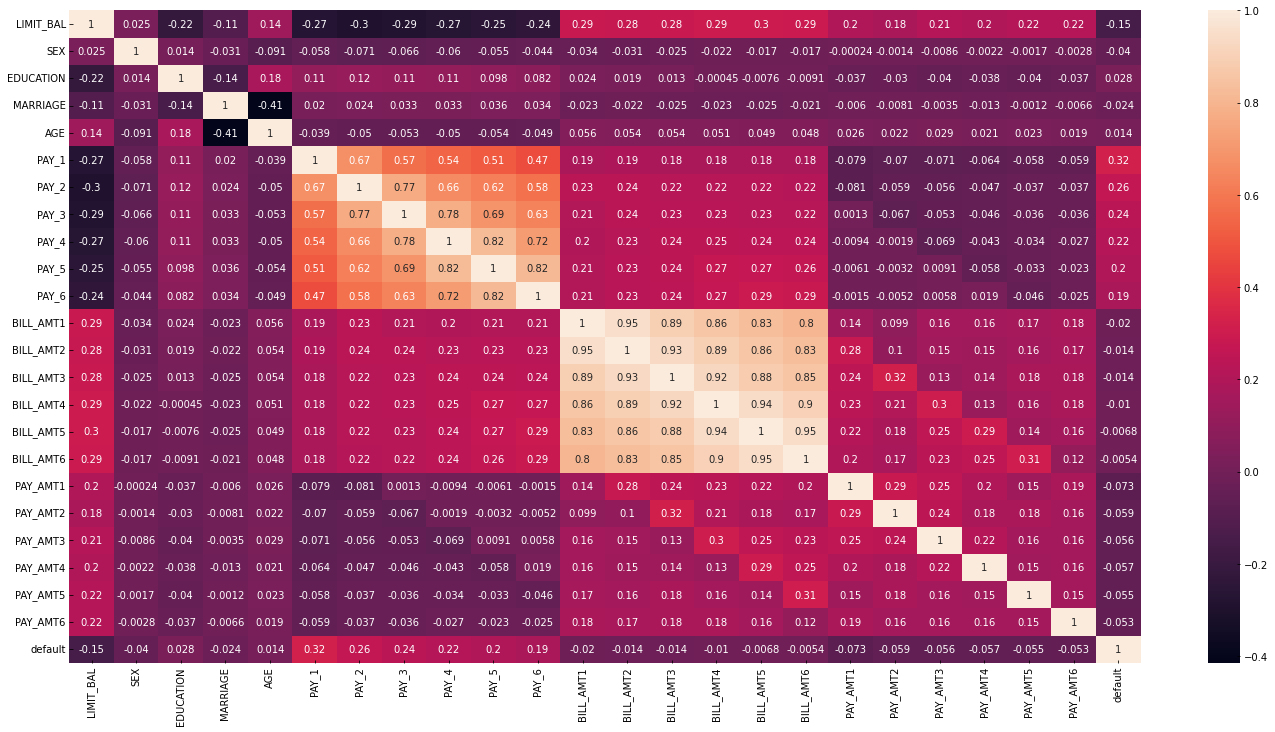

In [27]:
plt.figure(figsize=(24, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Feature engineering

In [28]:
df['bill_amt_mean'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']] \
                     .mean(axis=1)
df['bill_amt_std'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].std(axis=1)

df['pay_amt_mean'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
df['pay_amt_sum'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
df['pay_amt_std'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].std(axis=1)

df['pay_limit'] = df['PAY_AMT1'] / df['LIMIT_BAL']

# all PAY columns = 0, -1, -2 mean payments without delay

df[(df['PAY_1'] == -1) | (df['PAY_1'] == -2)] = 0
df[(df['PAY_2'] == -1) | (df['PAY_2'] == -2)] = 0
df[(df['PAY_3'] == -1) | (df['PAY_3'] == -2)] = 0
df[(df['PAY_4'] == -1) | (df['PAY_4'] == -2)] = 0

### Training

In [29]:
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [30]:
y_train.value_counts()

1    19175
0    19175
Name: default, dtype: int64

In [31]:
clf = RandomForestClassifier()

params = {'n_estimators': [200, 300],
          'max_depth': [7, 9, 11],
          'min_samples_split': [2, 3],
          'min_samples_leaf': [1, 2, 3]}

grid = GridSearchCV(clf, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

grid.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [32]:
model = RandomForestClassifier(**grid.best_params_)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"f1-score: {f1_score(y_test, y_pred, average='macro')}")
print()
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

f1-score: 0.7372046997592221

Confusion matrix:
[[5469  923]
 [ 290  818]]


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      6392
           1       0.47      0.74      0.57      1108

    accuracy                           0.84      7500
   macro avg       0.71      0.80      0.74      7500
weighted avg       0.88      0.84      0.85      7500



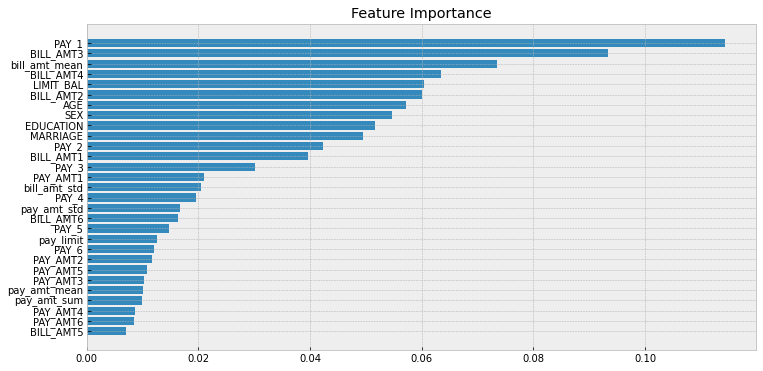

In [34]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()